In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import seaborn as sns
import pymc3 as pm
import theano
%matplotlib inline

In [2]:
df_med_county = pd.read_csv('data/medicare_county_level/medicare_county_all.csv', index_col=0)

In [3]:
df_med_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25528 entries, 0 to 3190
Columns: 244 entries, State to year
dtypes: int64(1), object(243)
memory usage: 47.7+ MB


In [4]:
df_med_county.head()

,State,County,State and County FIPS Code,Beneficiaries with Part A and Part B,FFS Beneficiaries,MA Beneficiaries,MA Participation Rate,Average Age,Percent Female,Percent Male,...,PQI11 Bacterial Pneumonia Admission Rate (age 65-74),PQI11 Bacterial Pneumonia Admission Rate (age 75+),PQI12 UTI Admission Rate (age < 65),PQI12 UTI Admission Rate (age 65-74),PQI12 UTI Admission Rate (age 75+),PQI15 Asthma in Younger Adults Admission Rate (age < 40),PQI16 Lower Extremity Amputation Admission Rate (age < 65),PQI16 Lower Extremity Amputation Admission Rate (age 65-74),PQI16 Lower Extremity Amputation Admission Rate (age 75+),year
0,National,NATIONAL TOTAL,.,42506654,33030525,9476129,22.29,72,56.06,43.94,...,804,2103,433,317,1228,416,114,45,52,2007
1,AK,STATE TOTAL,.,53956,53434,522,0.97,70,50.88,49.12,...,836,1912,*,166,860,*,122,*,*,2007
2,AK,ANCHORAGE,2020,21981,21752,229,1.04,69,53.29,46.71,...,.,.,.,.,.,.,.,.,.,2007
3,AK,BETHEL,2050,661,661,0,0,71,48.87,51.13,...,.,.,.,.,.,.,.,.,.,2007
4,AK,BRISTOL BAY,2060,*,630,*,*,68,49.37,50.63,...,.,.,.,.,.,.,.,.,.,2007


In [5]:
df_med_county.iloc[:,2:] = df_med_county.iloc[:,2:].apply(pd.to_numeric, errors='coerce', axis=1)

In [6]:
df_med_county.head()

,State,County,State and County FIPS Code,Beneficiaries with Part A and Part B,FFS Beneficiaries,MA Beneficiaries,MA Participation Rate,Average Age,Percent Female,Percent Male,...,PQI11 Bacterial Pneumonia Admission Rate (age 65-74),PQI11 Bacterial Pneumonia Admission Rate (age 75+),PQI12 UTI Admission Rate (age < 65),PQI12 UTI Admission Rate (age 65-74),PQI12 UTI Admission Rate (age 75+),PQI15 Asthma in Younger Adults Admission Rate (age < 40),PQI16 Lower Extremity Amputation Admission Rate (age < 65),PQI16 Lower Extremity Amputation Admission Rate (age 65-74),PQI16 Lower Extremity Amputation Admission Rate (age 75+),year
0,National,NATIONAL TOTAL,NaN,42506654.0,33030525.0,9476129.0,22.29,72.0,56.06,43.94,...,804.0,2103.0,433.0,317.0,1228.0,416.0,114.0,45.0,52.0,2007.0
1,AK,STATE TOTAL,NaN,53956.0,53434.0,522.0,0.97,70.0,50.88,49.12,...,836.0,1912.0,NaN,166.0,860.0,NaN,122.0,NaN,NaN,2007.0
2,AK,ANCHORAGE,2020.0,21981.0,21752.0,229.0,1.04,69.0,53.29,46.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007.0
3,AK,BETHEL,2050.0,661.0,661.0,0.0,0.00,71.0,48.87,51.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007.0
4,AK,BRISTOL BAY,2060.0,NaN,630.0,NaN,NaN,68.0,49.37,50.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007.0


In [7]:
df_med_county['Cost_per_Beneficiary'] = df_med_county['Total Actual Costs']/df_med_county['Beneficiaries with Part A and Part B']

In [8]:
state = df_med_county['State']
county = df_med_county['County']
year = df_med_county['year']
countyid = df_med_county['State and County FIPS Code']

#drop columns that are majority Nan
nullrate = df_med_county.isnull().sum()/df_med_county.shape[0]
mask = nullrate < 0.2
cols_tokeep_null = nullrate[mask]
df_med_county = df_med_county.filter(list(cols_tokeep_null.index))
cols_tokeep_null

State                                                               0.000000
County                                                              0.000000
State and County FIPS Code                                          0.017236
Beneficiaries with Part A and Part B                                0.018372
FFS Beneficiaries                                                   0.001254
MA Beneficiaries                                                    0.018372
MA Participation Rate                                               0.018372
Average Age                                                         0.001254
Percent Female                                                      0.001880
Percent Male                                                        0.001880
Percent Eligible for Medicaid                                       0.008187
Average HCC Score                                                   0.001254
Total Actual Costs                                                  0.001567

In [9]:
correlation_matrix = df_med_county.corr()
df_med_county.columns

Index(['State', 'County', 'State and County FIPS Code',
       'Beneficiaries with Part A and Part B', 'FFS Beneficiaries',
       'MA Beneficiaries', 'MA Participation Rate', 'Average Age',
       'Percent Female', 'Percent Male',
       ...
       'Ambulance Per User Standardized Costs', '# Ambulance Users',
       '% of Beneficiaries Using Ambulance',
       'Ambulance Events Per 1000 Beneficiaries',
       'Number of Acute Hospital Readmissions', 'Hospital Readmission Rate',
       'Emergency Department Visits',
       'Emergency Department Visits per 1000 Beneficiaries', 'year',
       'Cost_per_Beneficiary'],
      dtype='object', length=181)

In [10]:
correlation_costperben = correlation_matrix.iloc[:,-1]

In [11]:
correlation_costperben.sort_values()

MA Participation Rate                                              -0.674011
Procedures Standardized Costs as % of Total Standardized Costs     -0.298698
Procedures Actual Costs as % of Total Actual Costs                 -0.278640
Percent Male                                                       -0.238413
E&M Standardized Costs as % of Total Standardized Costs            -0.190674
OP Standardized Costs as % of Total Standardized Costs             -0.180747
E&M Actual Costs as % of Total Actual Costs                        -0.176828
DME Standardized Costs as % of Total Standardized Costs            -0.156284
IP Standardized Costs as % of Total Standardized Costs             -0.149336
DME Actual Costs as % of Total Actual Costs                        -0.135886
OP Actual Costs as % of Total Actual Costs                         -0.124227
IP Actual Costs as % of Total Actual Costs                         -0.113450
Part B Drugs Actual Costs as % of Total Actual Costs               -0.107836

In [12]:
#Keep anything with greater than 0.4 correlation coef
mask = (correlation_costperben > 0.3) | (correlation_costperben < -0.3)
fields_to_keep = correlation_costperben[mask]

In [13]:
colnames = fields_to_keep.index

In [14]:
df_med_county = df_med_county.filter(list(colnames))

In [15]:
df_med_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25528 entries, 0 to 3190
Data columns (total 27 columns):
MA Participation Rate                                          25059 non-null float64
Average HCC Score                                              25496 non-null float64
Actual Per Capita Costs                                        25488 non-null float64
Standardized Per Capita Costs                                  25488 non-null float64
Standardized Risk-Adjusted Per Capita Costs                    25488 non-null float64
IP Per Capita Actual Costs                                     25437 non-null float64
IP Per Capita Standardized Costs                               25437 non-null float64
% of Beneficiaries Using IP                                    25437 non-null float64
IP Covered Stays Per 1000 Beneficiaries                        25437 non-null float64
IP Covered Days Per 1000 Beneficiaries                         25437 non-null float64
PAC: SNF Per Capita Actual Costs

In [16]:
df_med_county.columns



Index(['MA Participation Rate', 'Average HCC Score', 'Actual Per Capita Costs',
       'Standardized Per Capita Costs',
       'Standardized Risk-Adjusted Per Capita Costs',
       'IP Per Capita Actual Costs', 'IP Per Capita Standardized Costs',
       '% of Beneficiaries Using IP',
       'IP Covered Stays Per 1000 Beneficiaries',
       'IP Covered Days Per 1000 Beneficiaries',
       'PAC: SNF Per Capita Actual Costs',
       'PAC: SNF Per Capita Standardized Costs',
       'PAC: SNF Per User Standardized Costs',
       'PAC: SNF Covered Stays Per 1000 Beneficiaries',
       'PAC: SNF Covered Days Per 1000 Beneficiaries',
       'PAC: HH Actual Costs as % of Total Actual Costs',
       'PAC: HH Per Capita Actual Costs', 'PAC: HH Per User Actual Costs',
       'PAC: HH Standardized Costs as % of Total Standardized Costs',
       'PAC: HH Per Capita Standardized Costs',
       'PAC: HH Per User Standardized Costs',
       '% of Beneficiaries Using PAC: HH',
       'PAC: HH Episodes P

In [17]:
df_med_county['State'] = state
df_med_county['County'] = county
df_med_county['year'] = year
df_med_county['CountyID'] = countyid

df_med_county.year = df_med_county.year.astype(int)

In [18]:
df_med_county.head()

,MA Participation Rate,Average HCC Score,Actual Per Capita Costs,Standardized Per Capita Costs,Standardized Risk-Adjusted Per Capita Costs,IP Per Capita Actual Costs,IP Per Capita Standardized Costs,% of Beneficiaries Using IP,IP Covered Stays Per 1000 Beneficiaries,IP Covered Days Per 1000 Beneficiaries,...,% of Beneficiaries Using PAC: HH,PAC: HH Episodes Per 1000 Beneficiaries,PAC: HH Visits Per 1000 Beneficiaries,Imaging Events Per 1000 Beneficiaries,% of Beneficiaries Using DME,Cost_per_Beneficiary,State,County,year,CountyID
0,22.29,1.0000,8271.85,7947.16,8218.21,3047.80,2593.17,0.2050,338.0,1901.0,...,0.0875,164.0,3246.0,4087.0,0.2860,6427.779999,National,NATIONAL TOTAL,2007,NaN
1,0.97,0.8530,6856.01,5453.02,6550.84,3210.91,2171.97,0.1647,247.0,1367.0,...,0.0402,61.0,950.0,3150.0,0.2167,6789.682568,AK,STATE TOTAL,2007,NaN
2,1.04,0.8743,6688.90,5401.74,6233.46,3156.64,2169.29,0.1609,244.0,1425.0,...,0.0444,64.0,1016.0,3747.0,0.2267,6619.210000,AK,ANCHORAGE,2007,2020.0
3,0.00,0.8318,7563.27,4185.52,5138.40,4080.24,2166.93,0.2088,316.0,1637.0,...,NaN,NaN,NaN,1030.0,0.1180,7563.268306,AK,BETHEL,2007,2050.0
4,NaN,0.7691,5874.40,4712.96,6982.94,3158.89,2104.14,0.1429,206.0,1129.0,...,0.0286,37.0,417.0,2987.0,0.1952,NaN,AK,BRISTOL BAY,2007,2060.0


In [19]:
corr = df_med_county.corr()

In [20]:
corr

,MA Participation Rate,Average HCC Score,Actual Per Capita Costs,Standardized Per Capita Costs,Standardized Risk-Adjusted Per Capita Costs,IP Per Capita Actual Costs,IP Per Capita Standardized Costs,% of Beneficiaries Using IP,IP Covered Stays Per 1000 Beneficiaries,IP Covered Days Per 1000 Beneficiaries,...,PAC: HH Per Capita Standardized Costs,PAC: HH Per User Standardized Costs,% of Beneficiaries Using PAC: HH,PAC: HH Episodes Per 1000 Beneficiaries,PAC: HH Visits Per 1000 Beneficiaries,Imaging Events Per 1000 Beneficiaries,% of Beneficiaries Using DME,Cost_per_Beneficiary,year,CountyID
MA Participation Rate,1.000000,0.178361,0.020253,-0.025009,-0.187264,0.017162,-0.071622,-0.239035,-0.179735,-0.089958,...,-0.046659,-0.055662,0.007793,-0.068555,-0.060726,0.020171,-0.211743,-0.674011,2.326145e-01,5.258150e-02
Average HCC Score,0.178361,1.000000,0.634212,0.674651,0.099065,0.542457,0.630209,0.486655,0.566463,0.670603,...,0.454030,0.381614,0.539107,0.436955,0.417827,0.639133,0.388985,0.344480,2.936865e-03,1.506319e-02
Actual Per Capita Costs,0.020253,0.634212,1.000000,0.894578,0.652651,0.761999,0.674533,0.421616,0.490024,0.546785,...,0.564117,0.473519,0.592657,0.546183,0.531648,0.542077,0.221134,0.714392,2.703928e-01,-1.385648e-02
Standardized Per Capita Costs,-0.025009,0.674651,0.894578,1.000000,0.750408,0.549206,0.751859,0.564314,0.615365,0.629095,...,0.684686,0.620495,0.693919,0.666446,0.639989,0.656831,0.444728,0.680423,1.757485e-01,1.329784e-02
Standardized Risk-Adjusted Per Capita Costs,-0.187264,0.099065,0.652651,0.750408,1.000000,0.289565,0.485604,0.363912,0.336110,0.261087,...,0.447414,0.427854,0.413608,0.437720,0.418378,0.361799,0.287174,0.622953,2.629979e-01,-1.367072e-02
IP Per Capita Actual Costs,0.017162,0.542457,0.761999,0.549206,0.289565,1.000000,0.770592,0.495359,0.575855,0.644198,...,0.229894,0.152549,0.292582,0.222795,0.216076,0.404190,0.107382,0.541097,2.994437e-02,-3.976997e-02
IP Per Capita Standardized Costs,-0.071622,0.630209,0.674533,0.751859,0.485604,0.770592,1.000000,0.790995,0.846354,0.833419,...,0.368295,0.330595,0.409119,0.359325,0.340819,0.600276,0.430898,0.544874,-1.228654e-01,-3.219189e-02
% of Beneficiaries Using IP,-0.239035,0.486655,0.421616,0.564314,0.363912,0.495359,0.790995,1.000000,0.958452,0.826546,...,0.311988,0.267619,0.330029,0.315853,0.307665,0.493983,0.505994,0.471304,-4.349590e-01,-3.859776e-02
IP Covered Stays Per 1000 Beneficiaries,-0.179735,0.566463,0.490024,0.615365,0.336110,0.575855,0.846354,0.958452,1.000000,0.894982,...,0.367474,0.325644,0.393403,0.367421,0.352975,0.543515,0.503924,0.482208,-3.772283e-01,-3.665668e-02
IP Covered Days Per 1000 Beneficiaries,-0.089958,0.670603,0.546785,0.629095,0.261087,0.644198,0.833419,0.826546,0.894982,1.000000,...,0.404788,0.360579,0.455102,0.397315,0.383266,0.610813,0.419732,0.457380,-3.310925e-01,-3.762475e-02


## Counties within States are different

Text(0,0.5,'Avg Cost/Beneficiary per County')

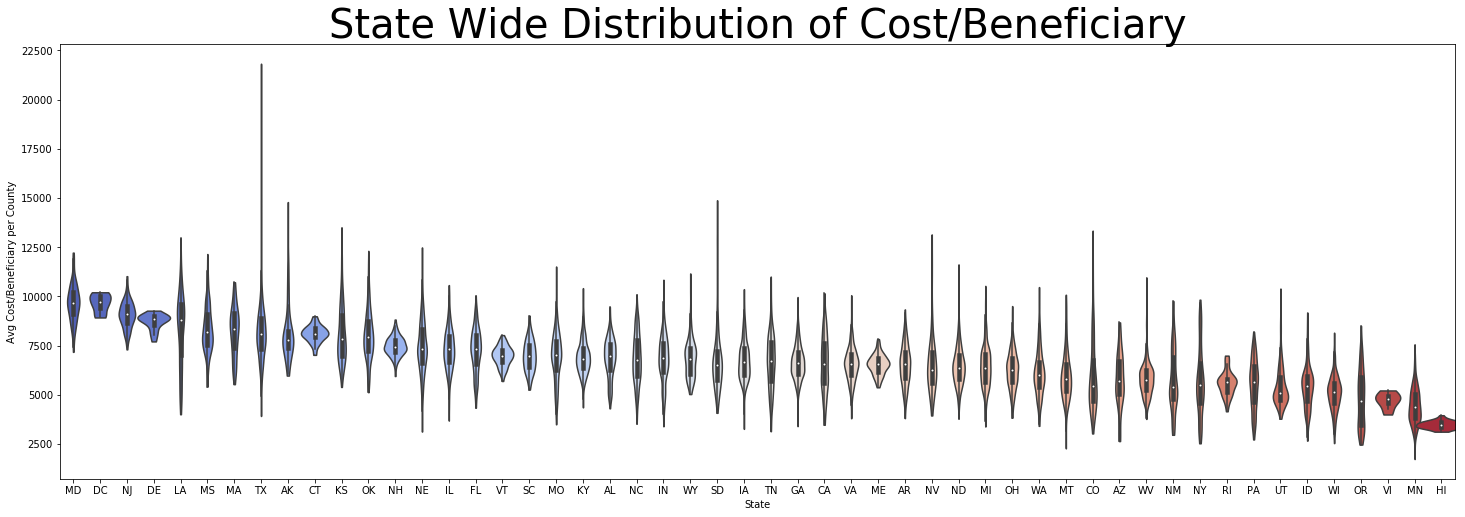

In [21]:
order = df_med_county.groupby('State').mean()['Cost_per_Beneficiary'].sort_values(ascending=False)
order.drop(['National','XX','PR'],inplace = True)

matplotlib.rcParams['figure.figsize'] = [25.0, 8.0]
sns.violinplot(x="State", y="Cost_per_Beneficiary",
        data=df_med_county, order= list(order.index), width = 1.9,palette="coolwarm", cut=0)
plt.title('State Wide Distribution of Cost/Beneficiary', fontsize=40)
plt.ylabel('Avg Cost/Beneficiary per County')

## States are different too

Text(0.5,0,'USA')

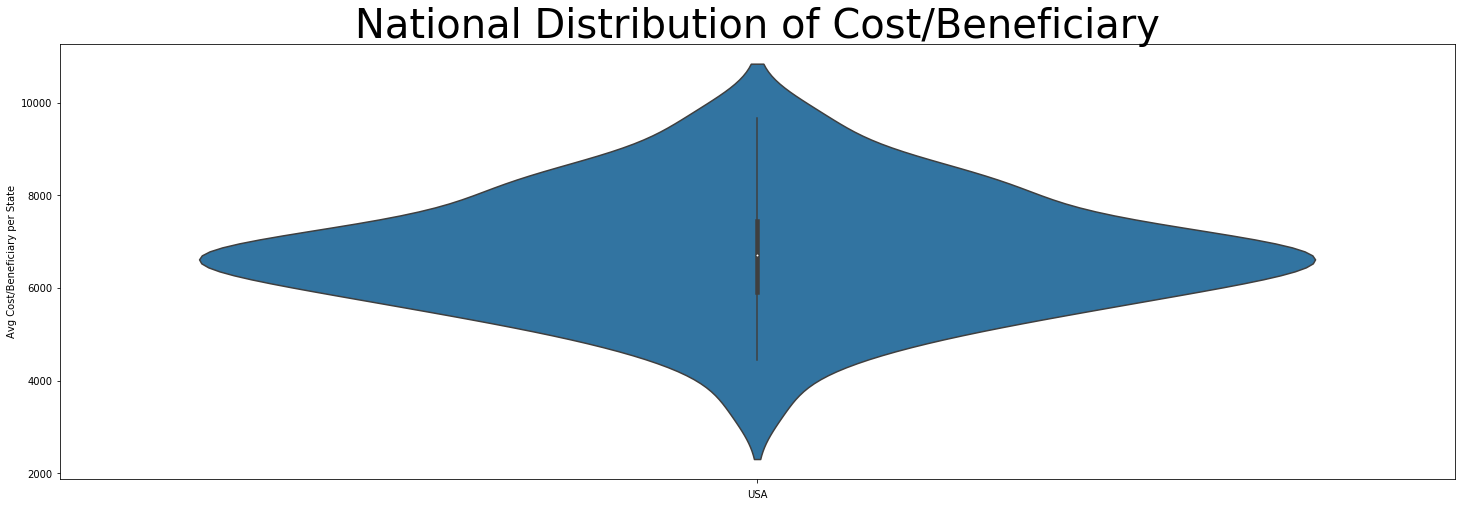

In [22]:
sns.violinplot(order, orient='v')
plt.title('National Distribution of Cost/Beneficiary', fontsize=40)
plt.ylabel('Avg Cost/Beneficiary per State')
plt.xlabel('USA')

## Linear Regression Model

In [23]:
df_med_county.columns


Index(['MA Participation Rate', 'Average HCC Score', 'Actual Per Capita Costs',
       'Standardized Per Capita Costs',
       'Standardized Risk-Adjusted Per Capita Costs',
       'IP Per Capita Actual Costs', 'IP Per Capita Standardized Costs',
       '% of Beneficiaries Using IP',
       'IP Covered Stays Per 1000 Beneficiaries',
       'IP Covered Days Per 1000 Beneficiaries',
       'PAC: SNF Per Capita Actual Costs',
       'PAC: SNF Per Capita Standardized Costs',
       'PAC: SNF Per User Standardized Costs',
       'PAC: SNF Covered Stays Per 1000 Beneficiaries',
       'PAC: SNF Covered Days Per 1000 Beneficiaries',
       'PAC: HH Actual Costs as % of Total Actual Costs',
       'PAC: HH Per Capita Actual Costs', 'PAC: HH Per User Actual Costs',
       'PAC: HH Standardized Costs as % of Total Standardized Costs',
       'PAC: HH Per Capita Standardized Costs',
       'PAC: HH Per User Standardized Costs',
       '% of Beneficiaries Using PAC: HH',
       'PAC: HH Episodes P

In [24]:
evetsper1000cols = ['MA Participation Rate', 'Average HCC Score',
       'IP Covered Stays Per 1000 Beneficiaries',
       'PAC: SNF Covered Stays Per 1000 Beneficiaries',
       'PAC: HH Visits Per 1000 Beneficiaries',
       'Imaging Events Per 1000 Beneficiaries', 
        'State', 'County', 'year','CountyID',
        'Cost_per_Beneficiary']
df_1000cols = df_med_county.filter(evetsper1000cols)

In [25]:
df_1000cols.dropna(inplace = True)

In [26]:
unique_county = df_1000cols.CountyID.unique()

In [27]:
df = df_1000cols.filter(['Cost_per_Beneficiary','CountyID','County','State','year','MA Participation Rate','IP Covered Stays Per 1000 Beneficiaries'])
df.year = preprocessing.scale(df.year)
df['MA_Part_Rate'] = preprocessing.scale(df['MA Participation Rate'])
df['IP_per_1000'] = preprocessing.scale(df['IP Covered Stays Per 1000 Beneficiaries'])

df.drop(['MA Participation Rate', 'IP Covered Stays Per 1000 Beneficiaries'],axis = 1, inplace = True)




#Do the same for States
states = df['State'].unique()
n_states = len(states)

state_lookup = pd.DataFrame({'state_idx': range(n_states), 'state': states})
df = df.merge(state_lookup, how = 'left', left_on = 'State', right_on = 'state')
df = df.drop(['State', 'state'], axis = 1)

df = df[df.state_idx < 5]
df

counties = df['CountyID'].unique()
n_counties = len(counties)

# Create a lookup table with the index 0 to n_counties matching to unique fips code
cty_lookup = pd.DataFrame({'cty_idx': range(n_counties), 'fips': counties})
# Merge the original dataframe with the cty_lookup table

df = df.merge(cty_lookup, how = 'left', left_on = 'CountyID', right_on = 'fips')
# Drop the fips code
df = df.drop(['CountyID', 'fips'], axis = 1)

df

/Users/Coho/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


,Cost_per_Beneficiary,County,year,MA_Part_Rate,IP_per_1000,state_idx,cty_idx
0,6619.210000,ANCHORAGE,-1.528287,-1.375269,-0.956933,0,0
1,5980.257930,FAIRBANKS NORTH STAR,-1.528287,-1.398110,-1.503028,0,1
2,7139.319632,JUNEAU,-1.528287,-1.411500,-0.863317,0,2
3,6473.279489,KENAI PENINSULA,-1.528287,-1.357941,-1.019344,0,3
4,6349.885070,MATANUSKA-SUSITNA,-1.528287,-1.346127,-1.097358,0,4
5,6178.872790,AUTAUGA,-1.528287,0.117274,0.322489,1,5
6,6020.460092,BALDWIN,-1.528287,-0.063879,0.400502,1,6
7,6319.637397,BARBOUR,-1.528287,-0.212739,0.790570,1,7
8,6021.787142,BIBB,-1.528287,0.649706,1.102624,1,8
9,5173.668282,BLOUNT,-1.528287,1.134881,0.962200,1,9


To really highlight the effect of the hierarchical linear regression we'll first estimate the non-hierarchical Bayesian model separate regressions. For each county a new estimate of the parameters is initiated. As we have no prior information on what the intercept or regressions could be we are placing a Normal distribution centered around 0 with a wide standard-deviation. We'll assume the measurements are normally distributed with noise ϵ on which we place a Half-Cauchy distribution.


In [28]:
county_names = df.cty_idx.unique()
year = df.year.unique()
data = df[df.cty_idx== 0]

data.shape == (8,7)
data.iloc[:,2:5]
data['Cost_per_Beneficiary']
X = data.iloc[:,2:5]
y = data['Cost_per_Beneficiary']
X_train = X[X.year != 1.529170]
X_test = X[X.year == max(year)]
X_train

,year,MA_Part_Rate,IP_per_1000
0,-1.528287,-1.375269,-0.956933
218,-1.091507,-1.356366,-1.112960
438,-0.654728,-1.298870,-1.284590
656,-0.217948,-1.358729,-1.362604
875,0.218832,-1.352428,-1.425015
1095,0.655611,-1.367393,-1.409412
1315,1.092391,-1.367393,-1.612247
1535,1.529170,-1.355578,-1.752672


In [29]:
# Fit a regression for each county
model = LinearRegression()
residuals = []
for county_name in county_names:
    data = df[df.cty_idx == county_name]
    if data.shape == (8,7):
        X = data.iloc[:,2:5]
        y = data['Cost_per_Beneficiary']
        X_train = X[X.year != 1.529170]
        X_test = X[X.year == max(year)]
        y_train = y[X.year != 1.529170]
        y_test = y[X.year == max(year)]
        model.fit(X_train,y_train)
        y_hat = model.predict(X_test)
        residuals.append(float(y_hat - y_test))

In [30]:
print('RMSE for basic linear regression on county level as a funtion of time: ',np.sqrt(np.mean(np.array(residuals)**2)))


RMSE for basic linear regression on county level as a funtion of time:  139.343523595


In [31]:
np.std(df.Cost_per_Beneficiary)

1177.6613406063977

In [32]:
#Split Data
#Standerdize Target 
df['Cost_per_Beneficiary'] = preprocessing.scale(df['Cost_per_Beneficiary'])


X = df

y = X.filter(['cty_idx','state_idx','Cost_per_Beneficiary'])
X_train = X[X.year != 1.529170]
X_test = X[X.year == max(year)]
y_train = y[X.year != 1.529170]
y_test = y[X.year == max(year)]

In [33]:
## Hierarchical Model 2 tiers
X_train

county_idx = X_train.cty_idx.values
X_train
county_idx = X_train.cty_idx.values
unique_cty = X_train.cty_idx.unique()
unique_cty




array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [75]:


with pm.Model() as hierarchical_model:
    # Hyperpriors
    mu_a = pm.Normal('mu_alpha', mu=0., sd=1)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=1)
    
    mu_b1 = pm.Normal('mu_beta1', mu=0., sd=1)
    sigma_b1 = pm.HalfCauchy('sigma_beta1', beta=1)
    
    mu_b2 = pm.Normal('mu_beta2', mu=0., sd=1)
    sigma_b2 = pm.HalfCauchy('sigma_beta2', beta=1)
    
    mu_b3 = pm.Normal('mu_beta3', mu=0., sd=1)
    sigma_b3 = pm.HalfCauchy('sigma_beta3', beta=1)

    # Intercept for each county, distributed around group mean mu_a
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=len(unique_cty))
    # Beta for each county, distributed around group mean mu_beta_i
    b1 = pm.Normal('beta1', mu=mu_b1, sd=sigma_b1, shape=len(unique_cty))
    b2 = pm.Normal('beta2', mu=mu_b2, sd=sigma_b2, shape=len(unique_cty))
    b3 = pm.Normal('beta3', mu=mu_b3, sd=sigma_b3, shape=len(unique_cty))

    # Model error
    eps = pm.Uniform('sigma_eps', lower = 0, upper = 5000)

    # Expected value
    x1 = X_train.year.values
    x2 = X_train.MA_Part_Rate.values
    x3 = X_train.IP_per_1000.values
    cost_est = a[county_idx] + b1[county_idx]*x1 + b2[county_idx]*x2 + b3[county_idx]*x3

    # Data likelihood
    y_like = pm.Normal('y_like', mu=cost_est, sd=eps, observed=X_train.Cost_per_Beneficiary)
    
    start = pm.find_MAP()
    step = pm.NUTS() 
with hierarchical_model:
    hierarchical_trace = pm.sample(1000,step,start,njobs=3)

logp = 6,188.3, ||grad|| = 4.451e+06: : 5001it [00:04, 1133.07it/s]                         

Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma_eps_interval__, beta3, beta2, beta1, alpha, sigma_beta3_log__, mu_beta3, sigma_beta2_log__, mu_beta2, sigma_beta1_log__, mu_beta1, sigma_alpha_log__, mu_alpha]
100%|██████████| 1500/1500 [00:47<00:00, 31.50it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


TypeError: unsupported operand type(s) for +=: 'NUTS' and 'int'

In [73]:
pm.traceplot(hierarchical_trace)

NameError: name 'hierarchical_trace' is not defined

In [ ]:
np.max(X_train.cty_idx.values)

Get trace values for individual parameters

In [76]:
alphas = hierarchical_trace.get_values('alpha', burn = 50)

In [77]:
beta1s = hierarchical_trace.get_values('beta1', burn = 50)
beta2s = hierarchical_trace.get_values('beta2', burn = 50)
beta3s = hierarchical_trace.get_values('beta3', burn = 50)

In [78]:
alpha_means = []
for j in range(alphas.shape[1]):
    alpha_means.append(np.mean(alphas[:,j]))


In [79]:
beta1_means = []
for j in range(beta1s.shape[1]):
    beta1_means.append(np.mean(beta1s[:,j]))

beta2_means = []
for j in range(beta2s.shape[1]):
    beta2_means.append(np.mean(beta2s[:,j]))

beta3_means = []
for j in range(beta3s.shape[1]):
    beta3_means.append(np.mean(beta3s[:,j]))

In [80]:
alphas.shape

(2850, 222)

In [81]:
X_test.shape

(222, 7)

In [185]:
x1 = X_test.year.values
x2 = X_test.MA_Part_Rate.values
x3 = X_test.IP_per_1000.values
y_hats = alpha_means + beta1_means * x1 + beta2_means * x2 +beta3_means * x3

In [ ]:
alphas.shape[1]

In [ ]:
len(y_hats)

In [186]:
y_test['y_pred_H1'] = y_hats


/Users/Coho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [85]:
y_test
from sklearn.metrics import mean_squared_error

In [87]:
RMSE = np.sqrt(mean_squared_error(y_test.y_pred_H1,y_test.Cost_per_Beneficiary))
print(RMSE)

0.641665953224


(-3, 3)

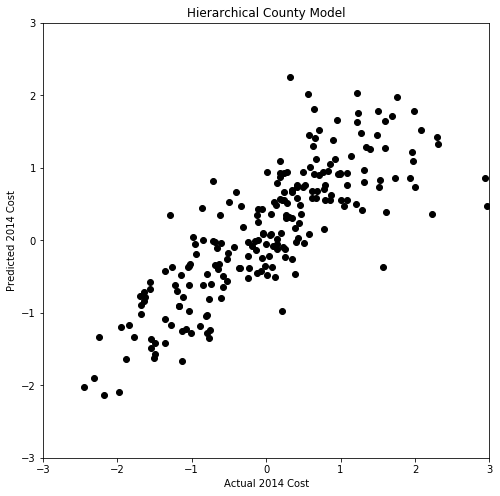

In [112]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(y_test.Cost_per_Beneficiary,y_test.y_pred_H1,'ko')
ax.set_xlabel('Actual 2014 Cost')
ax.set_ylabel('Predicted 2014 Cost')
ax.set_title('Hierarchical County Model')
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)

In [91]:
x1 = X_train.year.values
x2 = X_train.MA_Part_Rate.values
x3 = X_train.IP_per_1000.values

with pm.Model() as individual_model:
    # Intercept
    a = pm.Normal('alpha', mu=0, sd = 1)
    # Betas
    b1 = pm.Normal('beta1', mu=0, sd=1)
    b2 = pm.Normal('beta2', mu=0, sd = 1)
    b3 = pm.Normal('beta3', mu=0, sd = 1)

    # Model error prior
    eps = pm.HalfCauchy('eps', beta=1)

    # Linear model
    cost_est = a + b1*x1 + b2*x2 + b3*x3

    # Data likelihood
    y_like = pm.Normal('y_like', mu=cost_est, sd=eps, observed=X_train.Cost_per_Beneficiary)

    # Inference button (TM)!
    trace = pm.sample(progressbar=False)
    
    start = pm.find_MAP()
    step = pm.NUTS() 
    
with individual_model:
    individual_trace = pm.sample(500,step,start,njobs=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, beta3, beta2, beta1, alpha]
logp = -1,492.3, ||grad|| = 0.70687: 100%|██████████| 14/14 [00:00<00:00, 1580.50it/s]  
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eps_log__, beta3, beta2, beta1, alpha]
100%|██████████| 1000/1000 [00:01<00:00, 682.50it/s]


In [92]:
a = np.mean(individual_trace.get_values('alpha',burn = 50))
b1 = np.mean(individual_trace.get_values('beta1',burn = 50))
b2 = np.mean(individual_trace.get_values('beta2',burn = 50))
b3 = np.mean(individual_trace.get_values('beta3',burn = 50))


In [93]:
x1 = X_test.year.values
x2 = X_test.MA_Part_Rate.values
x3 = X_test.IP_per_1000.values
y_hats_pool = a + b1 * x1 + b2 * x2 +b2 * x3

In [187]:
y_test['y_pred_pool'] = y_hats_pool

/Users/Coho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [97]:
RMSE = np.sqrt(mean_squared_error(y_test.y_pred_pool,y_test.Cost_per_Beneficiary))
print(RMSE)

1.23304929307


(-3, 3)

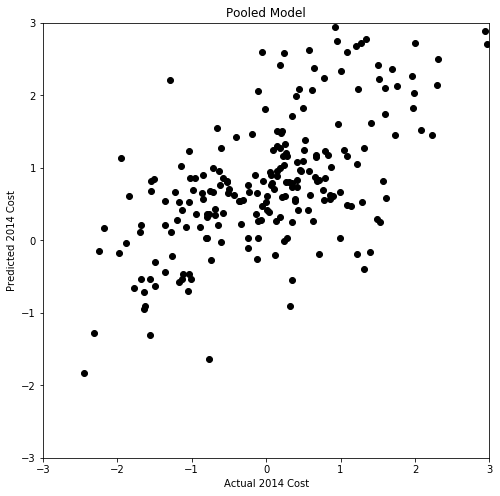

In [110]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(y_test.Cost_per_Beneficiary,y_test.y_pred_pool,'ko')
ax.set_xlabel('Actual 2014 Cost')
ax.set_ylabel('Predicted 2014 Cost')
ax.set_title('Pooled Model')
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)

In [100]:
county_names = X_train.cty_idx.unique()

indiv_traces = {}
for county_name in county_names:
    # Select subset of data belonging to county
    c_data = X_train[X_train.cty_idx == county_name]
    c_data = c_data.reset_index(drop=True)
    
    x1 = c_data.year.values
    x2 = c_data.MA_Part_Rate.values
    x3 = c_data.IP_per_1000.values
    
    with pm.Model() as individual_model:
        # Intercept
        a = pm.Normal('alpha', mu=0, sd = 1)
        # Betas
        b1 = pm.Normal('beta1', mu=0, sd=1)
        b2 = pm.Normal('beta2', mu=0, sd = 1)
        b3 = pm.Normal('beta3', mu=0, sd = 1)
    
        # Model error prior
        eps = pm.HalfCauchy('eps', beta=1)
    
        # Linear model
        cost_est = a + b1*x1 + b2*x2 + b3*x3
    
        # Data likelihood
        y_like = pm.Normal('y_like', mu=cost_est, sd=eps, observed=c_data.Cost_per_Beneficiary)

        # Inference button (TM)!
        
        
        start = pm.find_MAP()
        step = pm.NUTS() 
        
    indiv_traces[county_name] = trace

logp = 4.5112, ||grad|| = 0.28363: 100%|██████████| 36/36 [00:00<00:00, 2157.38it/s]  
logp = -8.0857, ||grad|| = 0.1653: 100%|██████████| 29/29 [00:00<00:00, 2177.03it/s]  
logp = -2.7273, ||grad|| = 0.00057713: 100%|██████████| 32/32 [00:00<00:00, 2000.92it/s]  
logp = -7.4446, ||grad|| = 0.37366: 100%|██████████| 27/27 [00:00<00:00, 2053.24it/s]  
logp = -2.2392, ||grad|| = 0.024692: 100%|██████████| 37/37 [00:00<00:00, 2127.07it/s]  
logp = 2.8879, ||grad|| = 0.49032: 100%|██████████| 38/38 [00:00<00:00, 2203.01it/s]  
logp = 6.9585, ||grad|| = 0.0074851: 100%|██████████| 44/44 [00:00<00:00, 2136.14it/s]  
logp = 7.0802, ||grad|| = 0.00013012: 100%|██████████| 32/32 [00:00<00:00, 2038.36it/s]  
logp = 3.1483, ||grad|| = 0.0022517: 100%|██████████| 33/33 [00:00<00:00, 2041.96it/s]  
logp = 8.3034, ||grad|| = 9.6284e-05: 100%|██████████| 43/43 [00:00<00:00, 2103.41it/s]  
logp = -6.4671, ||grad|| = 6.4943e-06: 100%|██████████| 22/22 [00:00<00:00, 1835.95it/s]  
logp = -3.4673, ||grad

logp = -3.0579, ||grad|| = 3.5089: 100%|██████████| 31/31 [00:00<00:00, 2211.02it/s]  
logp = -3.499, ||grad|| = 0.00037097: 100%|██████████| 33/33 [00:00<00:00, 1804.75it/s]  
logp = -7.112, ||grad|| = 0.19509: 100%|██████████| 31/31 [00:00<00:00, 2201.25it/s]  
logp = -2.9858, ||grad|| = 0.25092: 100%|██████████| 38/38 [00:00<00:00, 2039.07it/s]  
logp = 2.163, ||grad|| = 2.3118: 100%|██████████| 39/39 [00:00<00:00, 2002.64it/s]     
logp = 4.0335, ||grad|| = 0.0093864: 100%|██████████| 44/44 [00:00<00:00, 2072.14it/s]  
logp = -0.97624, ||grad|| = 0.017834: 100%|██████████| 31/31 [00:00<00:00, 2252.11it/s]  
logp = 6.6757, ||grad|| = 0.0070187: 100%|██████████| 53/53 [00:00<00:00, 1944.46it/s]  
logp = -1.008, ||grad|| = 0.002241: 100%|██████████| 35/35 [00:00<00:00, 1980.31it/s]   
logp = 4.8615, ||grad|| = 9.5908e-06: 100%|██████████| 52/52 [00:00<00:00, 2002.55it/s]  
logp = 4.8025, ||grad|| = 0.0026727: 100%|██████████| 53/53 [00:00<00:00, 2151.51it/s]   
logp = 2.6417, ||grad||

In [101]:
indiv_traces.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [103]:
y_hat_inds = []
for key, trace in indiv_traces.items():
    a = np.mean(trace.get_values('alpha'))
    b1 = np.mean(trace.get_values('beta1'))
    b2 = np.mean(trace.get_values('beta2'))
    b3 = np.mean(trace.get_values('beta3'))
    
    y_hat_ind = a + b1*X_test.iloc[key, 2] + b2*X_test.iloc[key, 3] + b3*X_test.iloc[key, 4]
    y_hat_inds.append(y_hat_ind)

In [188]:
y_test['y_pred_indv_cnty'] = y_hat_inds

/Users/Coho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [108]:
RMSE = np.sqrt(mean_squared_error(y_test.y_pred_indv_cnty,y_test.Cost_per_Beneficiary))
print(RMSE)

0.601965966934


(-3, 3)

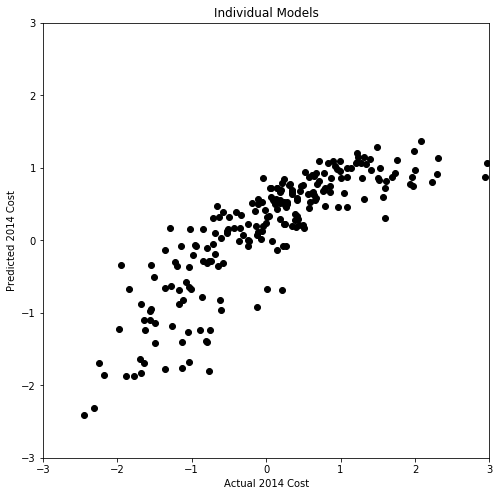

In [111]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(y_test.Cost_per_Beneficiary,y_test.y_pred_indv_cnty,'ko')
ax.set_xlabel('Actual 2014 Cost')
ax.set_ylabel('Predicted 2014 Cost')
ax.set_title('Individual Models')
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)

In [113]:
unique_state = X_train.state_idx.unique()
state_idx = X_train.state_idx.values

In [115]:

with pm.Model() as S_hierarchical_model:
    # Hyperpriors
    mu_a = pm.Normal('mu_alpha', mu=0., sd=1)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=1)
    
    mu_b1 = pm.Normal('mu_beta1', mu=0., sd=1)
    sigma_b1 = pm.HalfCauchy('sigma_beta1', beta=1)
    
    mu_b2 = pm.Normal('mu_beta2', mu=0., sd=1)
    sigma_b2 = pm.HalfCauchy('sigma_beta2', beta=1)
    
    mu_b3 = pm.Normal('mu_beta3', mu=0., sd=1)
    sigma_b3 = pm.HalfCauchy('sigma_beta3', beta=1)

    # Intercept for each county, distributed around group mean mu_a
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=len(unique_state))
    # Beta for each county, distributed around group mean mu_beta_i
    b1 = pm.Normal('beta1', mu=mu_b1, sd=sigma_b1, shape=len(unique_state))
    b2 = pm.Normal('beta2', mu=mu_b2, sd=sigma_b2, shape=len(unique_state))
    b3 = pm.Normal('beta3', mu=mu_b3, sd=sigma_b3, shape=len(unique_state))

    # Model error
    eps = pm.Uniform('sigma_eps', lower = 0, upper = 5000)

    # Expected value
    x1 = X_train.year.values
    x2 = X_train.MA_Part_Rate.values
    x3 = X_train.IP_per_1000.values
    cost_est = a[state_idx] + b1[state_idx]*x1 + b2[state_idx]*x2 + b3[state_idx]*x3

    # Data likelihood
    y_like = pm.Normal('y_like', mu=cost_est, sd=eps, observed=X_train.Cost_per_Beneficiary)
    
    start = pm.find_MAP()
    step = pm.NUTS() 
with S_hierarchical_model:
    S_hierarchical_trace = pm.sample(1000,step,start,njobs=3)

logp = -857.8, ||grad|| = 0.14114: 100%|██████████| 214/214 [00:00<00:00, 1272.82it/s] 
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma_eps_interval__, beta3, beta2, beta1, alpha, sigma_beta3_log__, mu_beta3, sigma_beta2_log__, mu_beta2, sigma_beta1_log__, mu_beta1, sigma_alpha_log__, mu_alpha]
100%|██████████| 1500/1500 [00:30<00:00, 49.01it/s]


In [116]:
Salphas = S_hierarchical_trace.get_values('alpha', burn = 50)
Sbeta1s = S_hierarchical_trace.get_values('beta1', burn = 50)
Sbeta2s = S_hierarchical_trace.get_values('beta2', burn = 50)
Sbeta3s = S_hierarchical_trace.get_values('beta3', burn = 50)


In [117]:
Salpha_means = []
for j in range(Salphas.shape[1]):
    Salpha_means.append(np.mean(Salphas[:,j]))
Sbeta1_means = []
for j in range(Sbeta1s.shape[1]):
    Sbeta1_means.append(np.mean(Sbeta1s[:,j]))

Sbeta2_means = []
for j in range(Sbeta2s.shape[1]):
    Sbeta2_means.append(np.mean(Sbeta2s[:,j]))

Sbeta3_means = []
for j in range(Sbeta3s.shape[1]):
    Sbeta3_means.append(np.mean(Sbeta3s[:,j]))

In [123]:
Salpha_means
s = y_test[y_test.state_idx == 0]
s

,cty_idx,state_idx,Cost_per_Beneficiary,y_pred_H1,y_pred_pool,y_pred_indv_cnty
1535,0,0,1.347092,1.286111,2.777420,1.048269
1536,1,0,0.640404,0.910243,3.303903,0.882425
1537,2,0,0.926255,1.126203,2.948635,1.019468
1538,3,0,1.273348,1.479259,2.724534,1.072305
1539,218,0,2.303159,1.334875,2.506306,1.131012
1540,4,0,1.210330,0.504859,2.675536,1.069469
1541,221,0,2.974337,0.471644,2.703503,1.066664
1542,220,0,0.610127,0.580645,3.204368,0.905974
1543,219,0,-0.045086,0.087392,3.393566,0.864389


In [133]:
y_hats_S_Hier = []
for i in unique_state:
    s = X_test[X_test.state_idx == i]
    x1 = s.year.values
    x2 = s.MA_Part_Rate.values
    x3 = s.IP_per_1000.values
    y_hat_s = Salpha_means[i] + Sbeta1_means[i] * x1 + Sbeta2_means[i] * x2 +Sbeta3_means[i] * x3
    y_hats_S_Hier.extend(y_hat_s)

In [135]:
len(y_hats_S_Hier)

222

In [189]:
y_test['y_pred_SHier'] = y_hats_S_Hier

/Users/Coho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [137]:
RMSE = np.sqrt(mean_squared_error(y_test.y_pred_SHier,y_test.Cost_per_Beneficiary))
print(RMSE)

0.421011829392


(-3, 3)

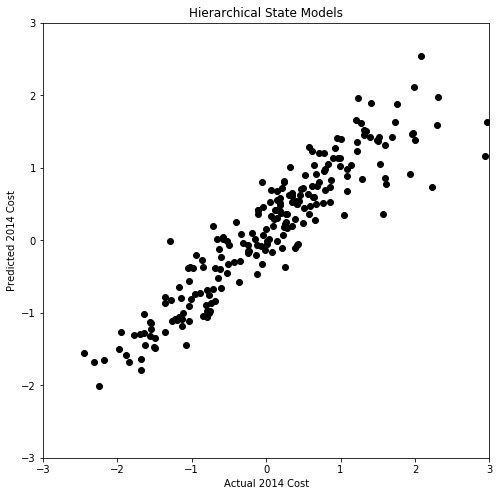

In [138]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(y_test.Cost_per_Beneficiary,y_test.y_pred_SHier,'ko')
ax.set_xlabel('Actual 2014 Cost')
ax.set_ylabel('Predicted 2014 Cost')
ax.set_title('Hierarchical State Models')
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)

In [140]:
state_names = X_train.state_idx.unique()

In [141]:
state_indiv_traces = {}
for state_name in state_names:
    # Select subset of data belonging to county
    c_data = X_train[X_train.cty_idx == state_name]
    c_data = c_data.reset_index(drop=True)
    
    x1 = c_data.year.values
    x2 = c_data.MA_Part_Rate.values
    x3 = c_data.IP_per_1000.values
    
    with pm.Model() as individual_model:
        # Intercept
        a = pm.Normal('alpha', mu=0, sd = 1)
        # Betas
        b1 = pm.Normal('beta1', mu=0, sd=1)
        b2 = pm.Normal('beta2', mu=0, sd = 1)
        b3 = pm.Normal('beta3', mu=0, sd = 1)
    
        # Model error prior
        eps = pm.HalfCauchy('eps', beta=1)
    
        # Linear model
        cost_est = a + b1*x1 + b2*x2 + b3*x3
    
        # Data likelihood
        y_like = pm.Normal('y_like', mu=cost_est, sd=eps, observed=c_data.Cost_per_Beneficiary)

        # Inference button (TM)!
        
        
        start = pm.find_MAP()
        step = pm.NUTS() 
        
    state_indiv_traces[state_name] = trace

logp = 4.5112, ||grad|| = 0.28363: 100%|██████████| 36/36 [00:00<00:00, 2041.16it/s]  
logp = -8.0857, ||grad|| = 0.1653: 100%|██████████| 29/29 [00:00<00:00, 2149.10it/s]  
logp = -2.7273, ||grad|| = 0.00057713: 100%|██████████| 32/32 [00:00<00:00, 2022.87it/s]  
logp = -7.4446, ||grad|| = 0.37366: 100%|██████████| 27/27 [00:00<00:00, 2034.35it/s]  
logp = -2.2392, ||grad|| = 0.024692: 100%|██████████| 37/37 [00:00<00:00, 2162.34it/s]  


In [143]:
y_hat_state_inds = []
for key, trace in state_indiv_traces.items():
    a = np.mean(trace.get_values('alpha'))
    b1 = np.mean(trace.get_values('beta1'))
    b2 = np.mean(trace.get_values('beta2'))
    b3 = np.mean(trace.get_values('beta3'))

    s = X_test[X_test.state_idx == key]
    x1 = s.year.values
    x2 = s.MA_Part_Rate.values
    x3 = s.IP_per_1000.values
    y_hat_s = a + b1 * x1 + b2 * x2 + b3 * x3
    y_hat_state_inds.extend(y_hat_s)

In [145]:
len(y_hat_state_inds)

222

In [190]:
y_test['y_pred_S_ind'] = y_hat_state_inds

/Users/Coho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [147]:
RMSE = np.sqrt(mean_squared_error(y_test.y_pred_S_ind,y_test.Cost_per_Beneficiary))
print(RMSE)

0.601965966934


(-3, 3)

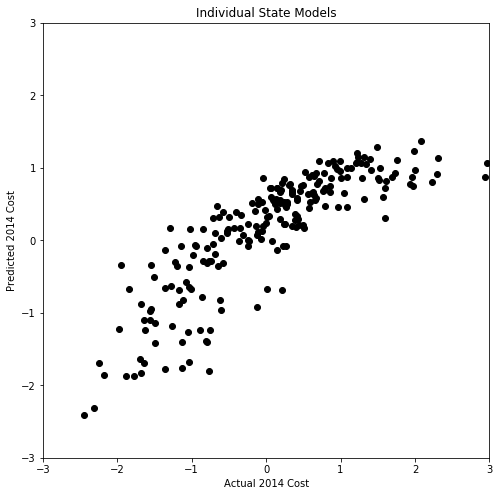

In [148]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(y_test.Cost_per_Beneficiary,y_test.y_pred_S_ind,'ko')
ax.set_xlabel('Actual 2014 Cost')
ax.set_ylabel('Predicted 2014 Cost')
ax.set_title('Individual State Models')
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)

In [191]:
y_test['pool_Res'] = y_test.y_pred_pool - y_test.Cost_per_Beneficiary
y_test['ind_cty_Res'] = y_test.y_pred_indv_cnty - y_test.Cost_per_Beneficiary
y_test['ind_state_Res'] = y_test.y_pred_S_ind - y_test.Cost_per_Beneficiary
y_test['hier_cty_Res'] = y_test.y_pred_H1 - y_test.Cost_per_Beneficiary
y_test['hier_st_Res'] = y_test.y_pred_SHier - y_test.Cost_per_Beneficiary


/Users/Coho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Coho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Coho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [153]:
y_test.columns

Index(['cty_idx', 'state_idx', 'Cost_per_Beneficiary', 'y_pred_H1',
       'y_pred_pool', 'y_pred_indv_cnty', 'y_pred_SHier', 'y_pred_S_ind',
       'pool_Res', 'ind_cty_Res', 'ind_state_Res', 'hier_cty_Res',
       'hier_st_Res'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c65a3f828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c6684f748>]], dtype=object)

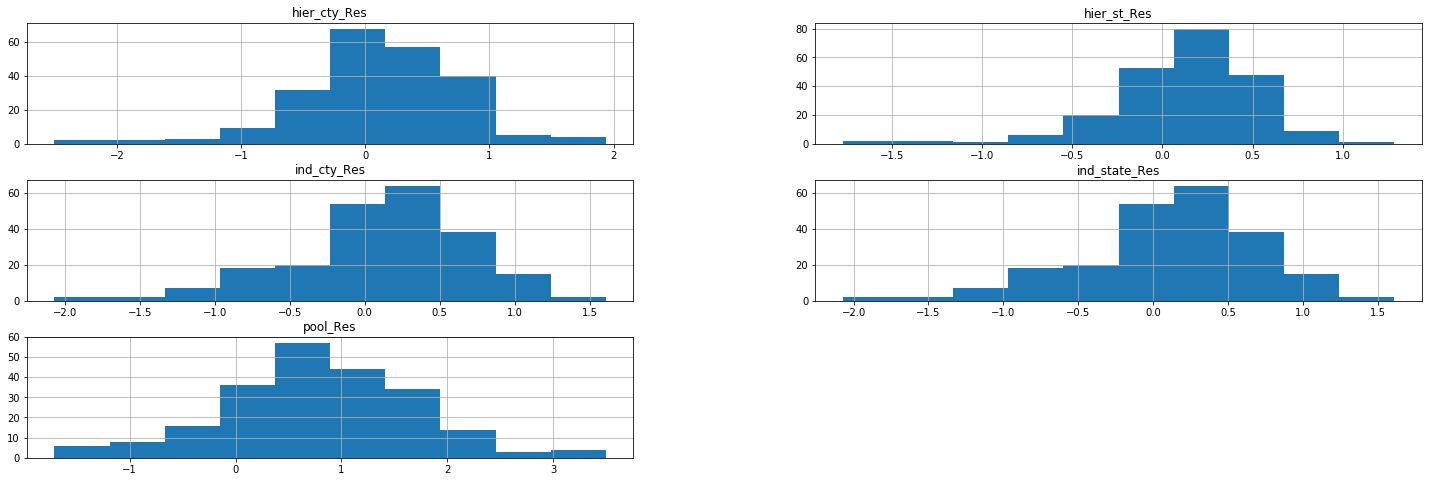

In [155]:
y_test.hist(column = ['pool_Res', 'ind_cty_Res', 'ind_state_Res', 'hier_cty_Res',
       'hier_st_Res'])

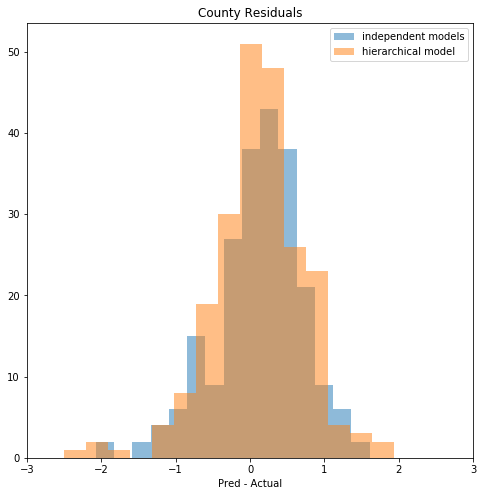

In [205]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#ax.hist(y_test.pool_Res,alpha = 0.5)
ax.hist(y_test.ind_cty_Res, bins = 15,label = 'independent models',alpha = 0.5)
ax.hist(y_test.hier_cty_Res, bins = 15,label = 'hierarchical model',alpha = 0.5)

ax.set_xlabel('Pred - Actual')
#ax.set_ylabel()
ax.set_title('County Residuals')
ax.set_xlim(-3,3)
ax.legend()


(-3, 3)

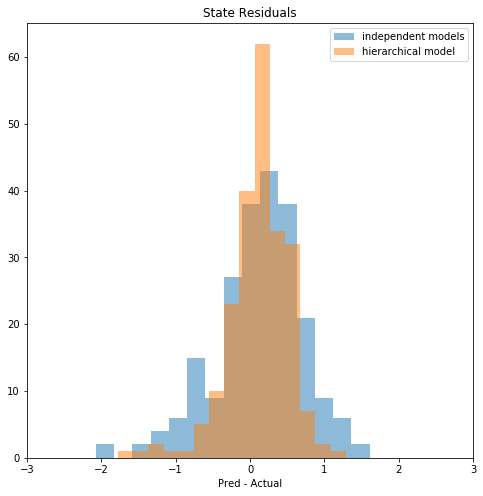

In [195]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#ax.hist(y_test.pool_Res,alpha = 0.5)
ax.hist(y_test.ind_state_Res,bins = 15, label = 'independent models',alpha = 0.5)
ax.hist(y_test.hier_st_Res,bins = 15, label = 'hierarchical model',alpha = 0.5)

ax.set_xlabel('Pred - Actual')
#ax.set_ylabel()
ax.set_title('State Residuals')
ax.legend()
ax.set_xlim(-3,3)


In [179]:
1177.6613406063977 * 0.421011829392


495.80935541293474

In [182]:
y_test

1756    8297.178415
Name: Cost_per_Beneficiary, dtype: float64

In [68]:
unique_state = X_train.state_idx.unique()
state_idx = X_train.state_idx.values
county_idx = X_train.cty_idx.values
unique_cty = X_train.cty_idx.unique()



with pm.Model() as SC_hierarchical_model:
    # Hyperpriors

    mu_a = pm.Normal('mu_alpha', mu=0., sd=1)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=1)
    
    mu_b1 = pm.Normal('mu_beta1', mu=0., sd=1)
    sigma_b1 = pm.HalfCauchy('sigma_beta1', beta=1)
    
    mu_b2 = pm.Normal('mu_beta2', mu=0., sd=1)
    sigma_b2 = pm.HalfCauchy('sigma_beta2', beta=1)
    
    mu_b3 = pm.Normal('mu_beta3', mu=0., sd=1)
    sigma_b3 = pm.HalfCauchy('sigma_beta3', beta=1)

    # Intercept for each state, distributed around group mean mu_a
    sa = pm.Normal('st_alpha', mu=mu_a, sd=sigma_a, shape=[len(unique_state),len(unique_cty)])
    # Beta for each state, distributed around group mean mu_beta_i
    sb1 = pm.Normal('st_beta1', mu=mu_b1, sd=sigma_b1, shape=[len(unique_state),len(unique_cty)])
    sb2 = pm.Normal('st_beta2', mu=mu_b2, sd=sigma_b2, shape=[len(unique_state),len(unique_cty)])
    sb3 = pm.Normal('st_beta3', mu=mu_b3, sd=sigma_b3, shape=[len(unique_state),len(unique_cty)])
    
    #for i in state_idx:
         # Intercept for each county, distributed around group mean mu_a
    #    a = pm.Normal('ct_alpha', mu=sa[i], sd=sigma_a, shape=[len(unique_state),len(unique_cty)])
        # Beta for each county, distributed around group mean mu_beta_i
    #    b1 = pm.Normal('ct_beta1', mu=sb1[i], sd=sigma_b1, shape=[len(unique_state),len(unique_cty)])
    #    b2 = pm.Normal('ct_beta2', mu=sb2[i], sd=sigma_b2, shape=[len(unique_state),len(unique_cty)])
    #    b3 = pm.Normal('ct_beta3', mu=sb3[i], sd=sigma_b3, shape=[len(unique_state),len(unique_cty)])

    

    # Model error
    eps = pm.Uniform('sigma_eps', lower = 0, upper = 5000)

    # Expected value
    x1 = X_train.year.values
    x2 = X_train.MA_Part_Rate.values
    x3 = X_train.IP_per_1000.values
    cost_est = a[state_idx,county_idx] + b1[state_idx,county_idx]*x1 + b2[state_idx,county_idx]*x2 + b3[state_idx,county_idx]*x3

    # Data likelihood
    y_like = pm.Normal('y_like', mu=cost_est, sd=eps, observed=X_train.Cost_per_Beneficiary)
    
    start = pm.find_MAP()
    step = pm.NUTS() 
with SC_hierarchical_model:
    SC_hierarchical_trace = pm.sample(1000,step,start,njobs=3)

MissingInputError: Input 0 of the graph (indices start from 0), used to compute AdvancedSubtensor(ct_beta3, TensorConstant{[0 0 0 ..., 4 4 4]}, TensorConstant{[  0   1  ..5 216 217]}), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

In [57]:
sa.




IndexError: tuple index out of range